# GraphRAG Demo - Jupyter Notebook
Welcome! This notebook will guide you through setting up and running the GraphRAG demo.

## Step 1: Load Environment Variables

In [1]:
import os
from dotenv import load_dotenv

load_dotenv()

print("✅ Environment Loaded")
print("OpenAI Key Present:", bool(os.getenv("OPENAI_API_KEY")))

✅ Environment Loaded
OpenAI Key Present: True


## Step 2: Create and Visualize a Simple Graph

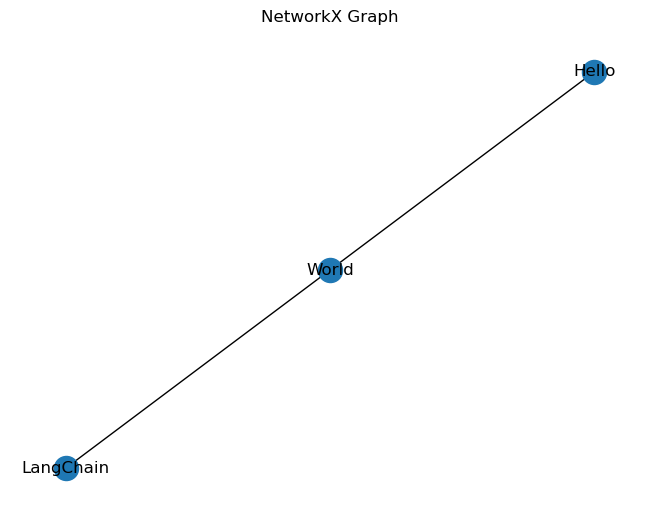

In [2]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.Graph()
G.add_edge("Hello", "World")
G.add_edge("World", "LangChain")

nx.draw(G, with_labels=True)
plt.title("NetworkX Graph")
plt.show()

## Step 3: Setup OpenAI Embeddings

In [3]:
from langchain_openai import OpenAIEmbeddings

embedding_model = OpenAIEmbeddings(model="text-embedding-3-small")
test_text = "This is a test sentence."
embedding_vector = embedding_model.embed_query(test_text)

print(f"✅ Generated Embedding Vector Length: {len(embedding_vector)}")

✅ Generated Embedding Vector Length: 1536


## Step 4: Initialize AstraDB Vector Store

In [4]:
from langchain_astradb import AstraDBVectorStore

vectorstore = AstraDBVectorStore(
    collection_name=os.getenv("ASTRA_DB_COLLECTION"),
    namespace=os.getenv("ASTRA_DB_KEYSPACE"),
    embedding=embedding_model,
)

print("🔗 AstraDB VectorStore Ready")

🔗 AstraDB VectorStore Ready


## Step 5: Download PDFs from S3

In [5]:
import boto3

BUCKET_NAME = "pacp-langflow-bucket"
PREFIX = "my_pdfs/"
LOCAL_FOLDER = "./"

os.makedirs(LOCAL_FOLDER, exist_ok=True)
s3_client = boto3.client("s3")

def download_pdfs_from_s3():
    try:
        response = s3_client.list_objects_v2(Bucket=BUCKET_NAME, Prefix=PREFIX)
        if "Contents" in response:
            for obj in response["Contents"]:
                file_key = obj["Key"]
                if file_key.endswith(".pdf"):
                    local_file_path = os.path.join(LOCAL_FOLDER, os.path.basename(file_key))
                    s3_client.download_file(BUCKET_NAME, file_key, local_file_path)
                    print(f"✅ Downloaded: {file_key} to {local_file_path}")
        else:
            print("No files found in the specified prefix.")
    except Exception as e:
        print(f"Error: {e}")

download_pdfs_from_s3()

Error: An error occurred (AccessDenied) when calling the ListObjectsV2 operation: User: arn:aws:iam::841162697161:user/appdev is not authorized to perform: s3:ListBucket on resource: "arn:aws:s3:::pacp-langflow-bucket" with an explicit deny in an identity-based policy


## Step 6: Load PDFs using LangChain

In [ ]:
from langchain_community.document_loaders import PyPDFLoader

pdf_files = [f for f in os.listdir(LOCAL_FOLDER) if f.endswith(".pdf")]
pages = []

for file in pdf_files:
    path = os.path.join(LOCAL_FOLDER, file)
    loader = PyPDFLoader(path)
    async for page in loader.alazy_load():
        pages.append(page)

print(f"✅ Loaded {len(pages)} pages from {len(pdf_files)} PDF files")

## Step 7: Save Documents to AstraDB

In [ ]:
vectorstore.add_documents(pages)
print("✅ Documents added to AstraDB")

## Step 8: Run a Vector Search Query

In [ ]:
import pprint

query_text = "Information about Plato"
results = vectorstore.similarity_search(query_text, k=3)

for doc in results:
    print(doc.page_content)
    pprint.pprint(doc.metadata)
    print("-------------------")